# Zgrubny opis metod i rozwiązań

1. Coś tam z merkatorem i reprezentacją pomiarów z gps na mapce:
- nasze dane wydają się ładnie rzutować na miejsca, w których powinny się znaleźć
- czy tak samo jest z surowego odczytu z GPS? Czy my mamy surowy odczyt z GPS? Nie wiem
2. Pozyskanie tras na podstawie współrzędnych geograficznych:
- sposób pierwszy: obliczanie odległości w linii prostej z twierdzenia pitagorasa ( można uzyć jako dolne ograniczenie)
- sposób drugi: dystans geodezyjny (dystans z uwzględnieniem krzywizny Ziemi, poprawny sposób do obliczania odległości w linii prostej, ale nam się nie przyda, biblioteka geopy)
- sposób trzeci: wyznaczenie tras przy użyciu API dowolnego silnika trasującego (przykłady to OSRM, Valhalla, GraphHopper, Google, korzystamy z tego pierwszego). Działa to dobrze i zawiera wiele dodatkowych informacji, my korzytamy jedynie z dystansu określonej trasy (routingpy, działa średnio, API client Jana Pomykacza, działa zajebiście xd).
- czego nie sposób odtworzyć: bez dodatkowych informacji nie jesteśmy w stanie określić natężenia ruchu, blokad, remontów, zmian tras itp. Są to trudno dostępne informacje, gdyż w trakcie dowozu jedzenia kurier zazwyczaj nie ma niewiadomo ilu czujników, tudzież aplikacji szpiegującej na telefonie.
3. Wizualizacje:
- Plotowanie bezpośrednie: folium: umożliwia tworzenie przybliżalnych map w html. Wiele tras powoduje spadek responsywności mapy, gdyż są to grafiki wektorowe. Umożliwia tworzenie heatmap (choropleth).
- Wygenerowanie grafiki rastrowej i nałożenie na mapę: (GDAL + Folium, albo inna libka do mapek): routy generują się do bitmap, które poźniej nakładamy na mapę
- Wygenerowanie heatmapy: (folium + ????): podzielenie mapy na kwadraty NxN metrów, jeśli route przechodzi przez kwadrat to zwiększ liczbę, wyplotuj kwadraty jako heatmapę.


In [ ]:
center_eendia_point = (21.9149, 78.0281)

In [ ]:
import folium
import requests

# Define start and end points
start_point = (22.745049, 75.892471)  # jakieś gunwo w berlinie
end_point = (22.765049 , 75.912471)     # jakieś gunwo w berlinie kawołek dalej

# points = (((75.892471, 22.745049)),((75.912471, 22.765049)))
# Create a map centered around the start point
mymap = folium.Map(location=start_point, zoom_start=6)
# for start_point, end_point in points:
    # Define the OSRM API URL
osrm_url = f'http://router.project-osrm.org/route/v1/driving/{start_point[1]},{start_point[0]};{end_point[1]},{end_point[0]}?overview=false&geometries=geojson&steps=true'

# Make a request to the OSRM API
response = requests.get(osrm_url)
data = response.json()
# steps = data['routes'][0]['legs'][0]['steps']

# Extract route coordinates from the response
route_coordinates = [[(point[1], point[0]) for point in data['routes'][0]['legs'][0]['steps'][i]['geometry']['coordinates']] for i in range(len(data['routes'][0]['legs'][0]['steps']))]

# Add a polyline to represent the route
folium.PolyLine(locations=route_coordinates, color='blue').add_to(mymap)

# Add markers for the start and end points
folium.Marker(location=start_point, icon=folium.Icon(color='green')).add_to(mymap)
folium.Marker(location=end_point, icon=folium.Icon(color='red')).add_to(mymap)

# Save the map to an HTML file
mymap.save("nearest_map.html")


In [ ]:
import folium
import pandas as pd
import ast

df_routes = pd.read_csv('routes/routes2.csv', delimiter=',')

routes = df_routes['Route-coordinates']
center_eendia_point = (21.9149, 78.0281)

# Create a map centered around the start point
mymap = folium.Map(location=center_eendia_point, zoom_start=6, prefer_canvas=True)
for str_route in routes:
    # Define the OSRM API URL
    route_coordinates = ast.literal_eval(str_route)
    # Extract route coordinates from the response
    # Add a polyline to represent the route
    # folium.PolyLine(locations=route_coordinates, color='rgba(0, 0, 255, 0.25)', weight=4).add_to(mymap)

    for coord in route_coordinates:
        for point in coord:
            folium.Circle(location=point, radius=1, color='rgba(0, 0, 255, 0.25)', fill=True,  weight=4).add_to(mymap)

    # Add markers for the start and end points
    # folium.Marker(location=start_point, icon=folium.Icon(color='green')).add_to(mymap)
    # folium.Marker(location=end_point, icon=folium.Icon(color='red')).add_to(mymap)

# Save the map to an HTML file
mymap.save("whole_eeendia.html")


In [ ]:
import folium
import json
import requests

# URL for a simple GeoJSON file for US states (you might need to find or host a suitable GeoJSON file for real-world applications)
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data"
)
state_geo = f"{url}/us-states.json"
geo_json_data = json.loads(requests.get(state_geo).text)

# Simulated data: number of points per state (example)
# In practice, this should be the result of your data processing
state_data = {
    'Alabama': 10, 'Alaska': 5, 'Arizona': 15, 'Arkansas': 7, 'California': 30,
    'Colorado': 20, 'Connecticut': 12, 'Delaware': 5, 'Florida': 25, 'Georgia': 17,
    # Add data for all states or ensure your GeoJSON keys match your data keys exactly
}

# Initialize a map centered on the USA
mymap = folium.Map(location=[37.8, -96], zoom_start=4)

# Create a choropleth map
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=state_data,
    columns=['State', 'Density'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',  # Color scheme
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Sample Points Per State'
).add_to(mymap)

folium.LayerControl().add_to(mymap)

# Save to HTML
mymap.save('us_states_heatmap.html')


In [ ]:
import folium
import json
import requests

# URL for a GeoJSON file for Indian states
url = "https://raw.githubusercontent.com/Subhash9325/GeoJson-Data-of-Indian-States/master/Indian_States"
state_geo = url
geo_json_data = json.loads(requests.get(state_geo).text)

# Simulated data: number of points per state (example)
# In practice, this should be the result of your data processing
state_data = {
    'Andhra Pradesh': 10, 'Arunachal Pradesh': 5, 'Assam': 15, 'Bihar': 7, 'Chhattisgarh': 30,
    'Goa': 20, 'Gujarat': 12, 'Haryana': 5, 'Himachal Pradesh': 25, 'Jharkhand': 17,
    'Karnataka': 10, 'Kerala': 5, 'Madhya Pradesh': 15, 'Maharashtra': 7, 'Manipur': 30,
    'Meghalaya': 20, 'Mizoram': 12, 'Nagaland': 5, 'Odisha': 25, 'Punjab': 17,
    'Rajasthan': 10, 'Sikkim': 5, 'Tamil Nadu': 15, 'Telangana': 7, 'Tripura': 30,
    'Uttar Pradesh': 20, 'Uttarakhand': 12, 'West Bengal': 5, 'Andaman and Nicobar Islands': 25,
    'Chandigarh': 17, 'Dadra and Nagar Haveli and Daman and Diu': 10, 'Lakshadweep': 5,
    'Delhi': 15, 'Puducherry': 7,
    # Add data for all states or ensure your GeoJSON keys match your data keys exactly
}

# Initialize a map centered on India
mymap = folium.Map(location=[20.5937, 78.9629], zoom_start=4)

# Create a choropleth map
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=state_data,
    columns=['State', 'Density'],
    key_on='feature.properties.NAME_1',
    fill_color='YlOrRd',  # Color scheme
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Sample Points Per State (India)'
).add_to(mymap)

folium.LayerControl().add_to(mymap)

# Save to HTML
mymap.save('india_states_heatmap.html')


In [ ]:
import folium
import pandas as pd
import ast
from geojson import Polygon, Feature, FeatureCollection

df_routes = pd.read_csv('routes/routes2.csv', delimiter=',')

routes = df_routes['Route-coordinates']
center_eendia_point = (21.9149, 78.0281)
# routes = routes.head(20)
polygon_collection = []
for str_route in routes:
    route = ast.literal_eval(str_route)
    polygon = Polygon(route)
    polygon_collection.append(Feature(geometry=polygon))
polygons = FeatureCollection(polygon_collection)
mymap = folium.Map(location=center_eendia_point, zoom_start=6, prefer_canvas=True)
geojson_data = folium.GeoJson(polygons, style_function=lambda feature:{"color":"blue"}).add_to(mymap)
# mymap.fit_bounds(geojson_data.get_bounds())
mymap.save("goejson_test.html")

In [ ]:
# saving data to geojson
import geojson
import ast
import pandas as pd

def single_route_to_geojson(coordinates: list[list[tuple]]):
    route = []
    for sublist in coordinates[:-1]:    #API returned double endpoint at the end. Messes geojson
        inverted_coords = [(lon, lat) for lat, lon in sublist]
        route.extend(inverted_coords)
    polygon = geojson.Polygon(route)
    feature = geojson.Feature(geometry=polygon)
    return feature

df_routes = pd.read_csv('routes2.csv', delimiter=',')
routes = df_routes['Route-coordinates']

all_features = []
for str_route in routes[:2]:
    route = ast.literal_eval(str_route)
    all_features.append(single_route_to_geojson(route))

geojson_data = geojson.FeatureCollection(all_features)

# Save all routes as one GeoJSON file
with open("test.geojson", "w") as f:
    geojson.dump(geojson_data, f, sort_keys=True)

In [ ]:
# validate geojson this doesnt work i dont care, should be proper format i think
import geojson
from shapely.geometry import shape

# Read the GeoJSON file
with open('all_routes.geojson', 'r') as f:
    geojson_data = geojson.load(f)


# Validate geometries (optional)
for feature in geojson_data['features']:
    for i, sub_feature in enumerate(feature):
        geom = shape(sub_feature['geometry'])
        if not geom.is_valid:
            print(f"Invalid geometry {i}: {sub_feature}")
# for feature in geojson_data['features']:
#     for geometry in feature['geometry']['geometries']:
#         geom = shape(geometry)
#         if not geom.is_valid:
#             print(f"Invalid geometry: {geometry}")


In [ ]:
import geojson
from shapely.geometry import shape
with open('all_routes.geojson', 'r') as f:
    geojson_data = geojson.load(f)

features = geojson_data['features']
print(features)
# sub_feature = feature[0]
# geom = shape(sub_feature['geometry'])
# print(sub_feature)

In [ ]:
import folium
import json

# Read GeoJSON data
with open('all_routes.geojson') as f:
    geojson_data = json.load(f)

# Create a Folium map
m = folium.Map(location=center_eendia_point, zoom_start=10)

# Add GeoJSON layer to the map
folium.GeoJson(geojson_data, style_function=lambda feature:{"color":"blue"}).add_to(m)

# Display the map
m.save('map_with_geojson.html')

In [ ]:
import os
import numpy as np
import folium
from osgeo import gdal, osr

def geojson_to_raster(input_geojson, output_raster, pixel_size):
    # Load the GeoJSON file
    src_ds = gdal.OpenEx(input_geojson)

    # Get the spatial reference
    srs = osr.SpatialReference()
    srs.ImportFromWkt(src_ds.GetProjection())

    # Create an empty list to store all geometries
    geometries = []

    # Iterate through the layers in the dataset
    for layer_idx in range(src_ds.GetLayerCount()):
        layer = src_ds.GetLayerByIndex(layer_idx)
        # Iterate through the features in each layer
        for feature in layer:
            # Get the geometry of the feature
            geom = feature.GetGeometryRef()
            # Append the geometry to the list
            geometries.append(geom)

    # Check if there are any geometries
    if not geometries:
        print("No geometries found in the GeoJSON file.")
        return

    # Get the bounding box of all geometries
    geom_union = geometries[0]
    for geom in geometries[1:]:
        geom_union = geom_union.Union(geom)
    x_min, x_max, y_min, y_max = geom_union.GetEnvelope()

    # Calculate number of columns and rows
    cols = int((x_max - x_min) / pixel_size)
    rows = int((y_max - y_min) / pixel_size)

    # Create an in-memory raster
    mem_driver = gdal.GetDriverByName('MEM')
    mem_ds = mem_driver.Create('', cols, rows, 1, gdal.GDT_Byte)

    # Set the geotransform and projection
    mem_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    mem_ds.SetProjection(srs.ExportToWkt())

    # Rasterize the geometries onto the raster
    for geom in geometries:
        gdal.RasterizeLayer(mem_ds, [1], layer, burn_values=[1])

    # Write the raster to disk
    driver = gdal.GetDriverByName('GTiff')
    driver.CreateCopy(output_raster, mem_ds, 0)

    # Clean up
    mem_ds = None
    src_ds = None



def display_map_with_raster(raster_file, map_center, zoom):
    # Load raster data
    raster_ds = gdal.Open(raster_file)
    raster_array = raster_ds.GetRasterBand(1).ReadAsArray()

    # Generate colormap
    colormap = {
        0: 'transparent',
        1: 'red'  # Color for your routes
    }

    # Create a Folium map
    m = folium.Map(location=map_center, zoom_start=zoom)

    # Add raster layer
    folium.raster_layers.ImageOverlay(
        image=raster_array,
        bounds=[[raster_ds.GetGeoTransform()[3] + raster_array.shape[0]*raster_ds.GetGeoTransform()[5],
                 raster_ds.GetGeoTransform()[0]],
                [raster_ds.GetGeoTransform()[3],
                 raster_ds.GetGeoTransform()[0] + raster_array.shape[1]*raster_ds.GetGeoTransform()[1]]],
        opacity=0.6,
        colorscale=colormap
    ).add_to(m)

    # Display the map
    m.save('raster_routes.html')

# Input parameters
input_geojson = 'all_routes.geojson'
output_raster = 'output_raster.tif'
pixel_size = 0.0001  # Adjust pixel size as needed
map_center = center_eendia_point  # Center of your map
zoom = 10  # Adjust the zoom level as needed

# Convert GeoJSON to raster
geojson_to_raster(input_geojson, output_raster, pixel_size)

# Display map with raster overlay
display_map_with_raster(output_raster, map_center, zoom)


### TODO for this faking heatmap
1. for every city find min and max for lat and long, this will be bounding box: add to it little bit, so it is slightly greater
2. count how much square meters is one pixel (roughly) (need to know how ox makes images)
3. Adjust image size (i mean resolution to some normal values)
4. create mapping for each pixel to coordinates
5. map those coordinates from routes to each bounding box


### Notes
when plotting with ox, it takes gdf_edges (graph_to_gdf without nodes, ["geometry]) and gets its total bounds. Below code explains how to get and how to set dpi to get desired amount of pixels for given graph.
Graphs will get different results based on different geo spans. Due to this, sometimes we also need to get precise span from the axes (limits?)
```# Get the bounding box of the plot in display coordinates
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

#### Calculate the width and height of the plot in pixels
width = bbox.width * fig.dpi
height = bbox.height * fig.dpi
```
`you can skip nodes`

After plotting ```ax/.get_(x/y)lim ``` gets proper coordinate bbox, made from creating graph.

Plotting data as cretin, and all of the above should be saved as image metadata.

Try add inferno cmap to ax.imshow

### How to calculate real area of one pixel
```
# Calculate the width and height of the bounding box in degrees
width_deg = east - west # width is long
height_deg = north - south # height is lat
 
# Convert degrees to meters (1 degree latitude ~= 111,320 meters, 1 degree longitude ~= 111,320 meters * cos(latitude))
m_per_deg_lat = 111320
m_per_deg_lon = 111320 * abs(np.cos(np.radians((south + north) / 2)))

# Convert degrees to meters
width_m = width_deg * m_per_deg_lon
height_m = height_deg * m_per_deg_lat

# Define the size of the plot in pixels
plot_width_px = 1000
plot_height_px = 1000

# Calculate the area represented by one pixel
area_per_pixel = (width_m * height_m) / (plot_width_px * plot_height_px)
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# routes_df = pd.read_csv("../routes2.csv")
routes_df = pd.read_csv("../new_data_delivery.csv")
distance = routes_df["Delivery_person_Ratings"]
distance.head()


0    4.9
1    4.5
2    4.4
3    4.7
4    4.6
Name: Delivery_person_Ratings, dtype: float64

In [2]:
import numpy as np
bins = [i/10 for i in range(0, 50)]
counts, bins = np.histogram(distance, bins=bins)
counts

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,    18,    19,
          20,    17,    18,     5,    25,    26,    23,    30,   228,
         187,   197,   211,   169,   953,  1278,  1286,  1255,  1190,
        2726,  5720,  5784, 11631], dtype=int64)

Text(0, 0.5, 'Occurences')

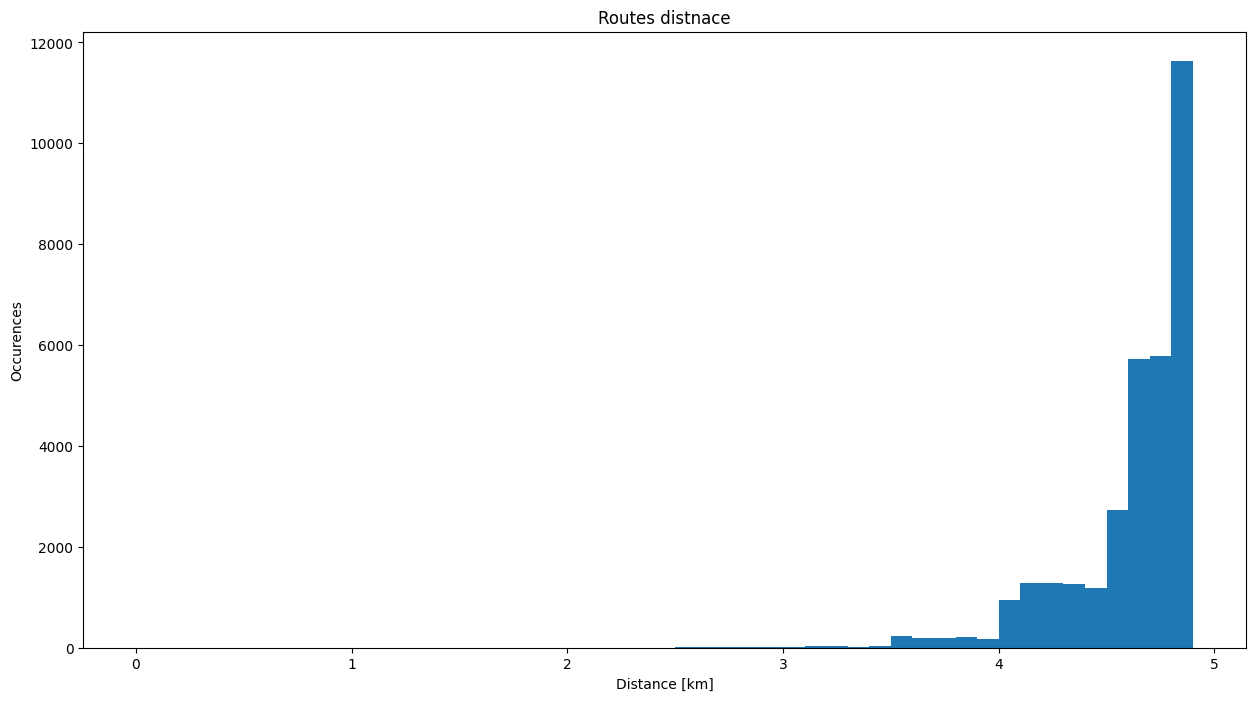

In [3]:


fig, ax = plt.subplots(figsize=(15,8))
ax.hist(x=distance, bins=bins)
ax.set_title("Routes distnace")
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Occurences")

Text(0, 0.5, 'Occurences')

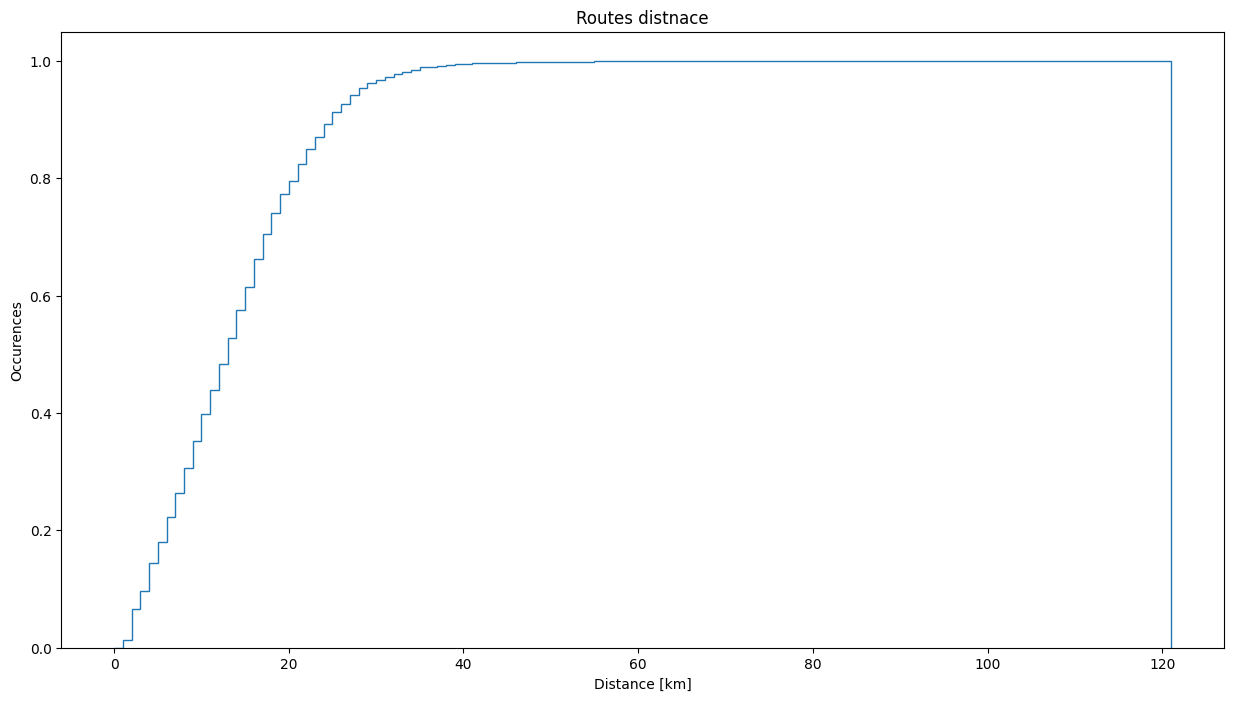

In [5]:
bins = [i for i in range(0, int(max(distance))+1)]

fig, ax = plt.subplots(figsize=(15,8))
ax.hist(x=distance, bins=bins, density=True, cumulative=True, histtype='step')
ax.set_title("Routes distnace")
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Occurences")

In [4]:
distance.describe(percentiles=[.05,.25,.5,.75,.95,.96,.97,.98,.99])

count    36310.000000
mean         4.626522
std          0.321237
min          2.500000
5%           4.000000
25%          4.500000
50%          4.700000
75%          4.800000
95%          5.000000
96%          5.000000
97%          5.000000
98%          5.000000
99%          5.000000
max          5.000000
Name: Delivery_person_Ratings, dtype: float64

In [7]:
p = sum(counts[:31])/sum(counts)
p

0.9677463780091445

In [34]:
cluster_city = {
    0 : "Mysuru",
    1 : "Vadodara",
    2 : "Ranchi",
    3 : "Jaipur",
    4 : "Hyderabad",
    5 : "Mumbai",
    6 : "Chennai",
    7 : "Indore",
    8 : "Prayagraj",
    9 : "Ludhiana",
    10 : "Pune",
    11 : "Kolkata",
    12 : "Coimbatore",
    13 : "Panaji",
    14 : "Surat",
    15 : "Bengaluru",
    16 : "Dehradun",
    17 : "Agra",
    18 : "Kanpur",
    19 : "Aurangabad",
    20 : "Bhopal",
    21 : "Kochi"

}

In [35]:
clusters = pd.read_csv("../clusters.csv")
clusters = clusters["cluster_n"].map(cluster_city)
sum_in_city = clusters.value_counts()
sum_in_city

cluster_n
Jaipur        3421
Bengaluru     3173
Surat         3165
Hyderabad     3163
Coimbatore    3152
Mumbai        3148
Indore        3142
Chennai       3121
Pune          3115
Vadodara      2994
Ranchi        2545
Mysuru        1564
Kochi          682
Ludhiana       670
Kolkata        667
Kanpur         651
Panaji         586
Prayagraj      555
Agra           536
Aurangabad     534
Dehradun       475
Bhopal         463
Name: count, dtype: int64

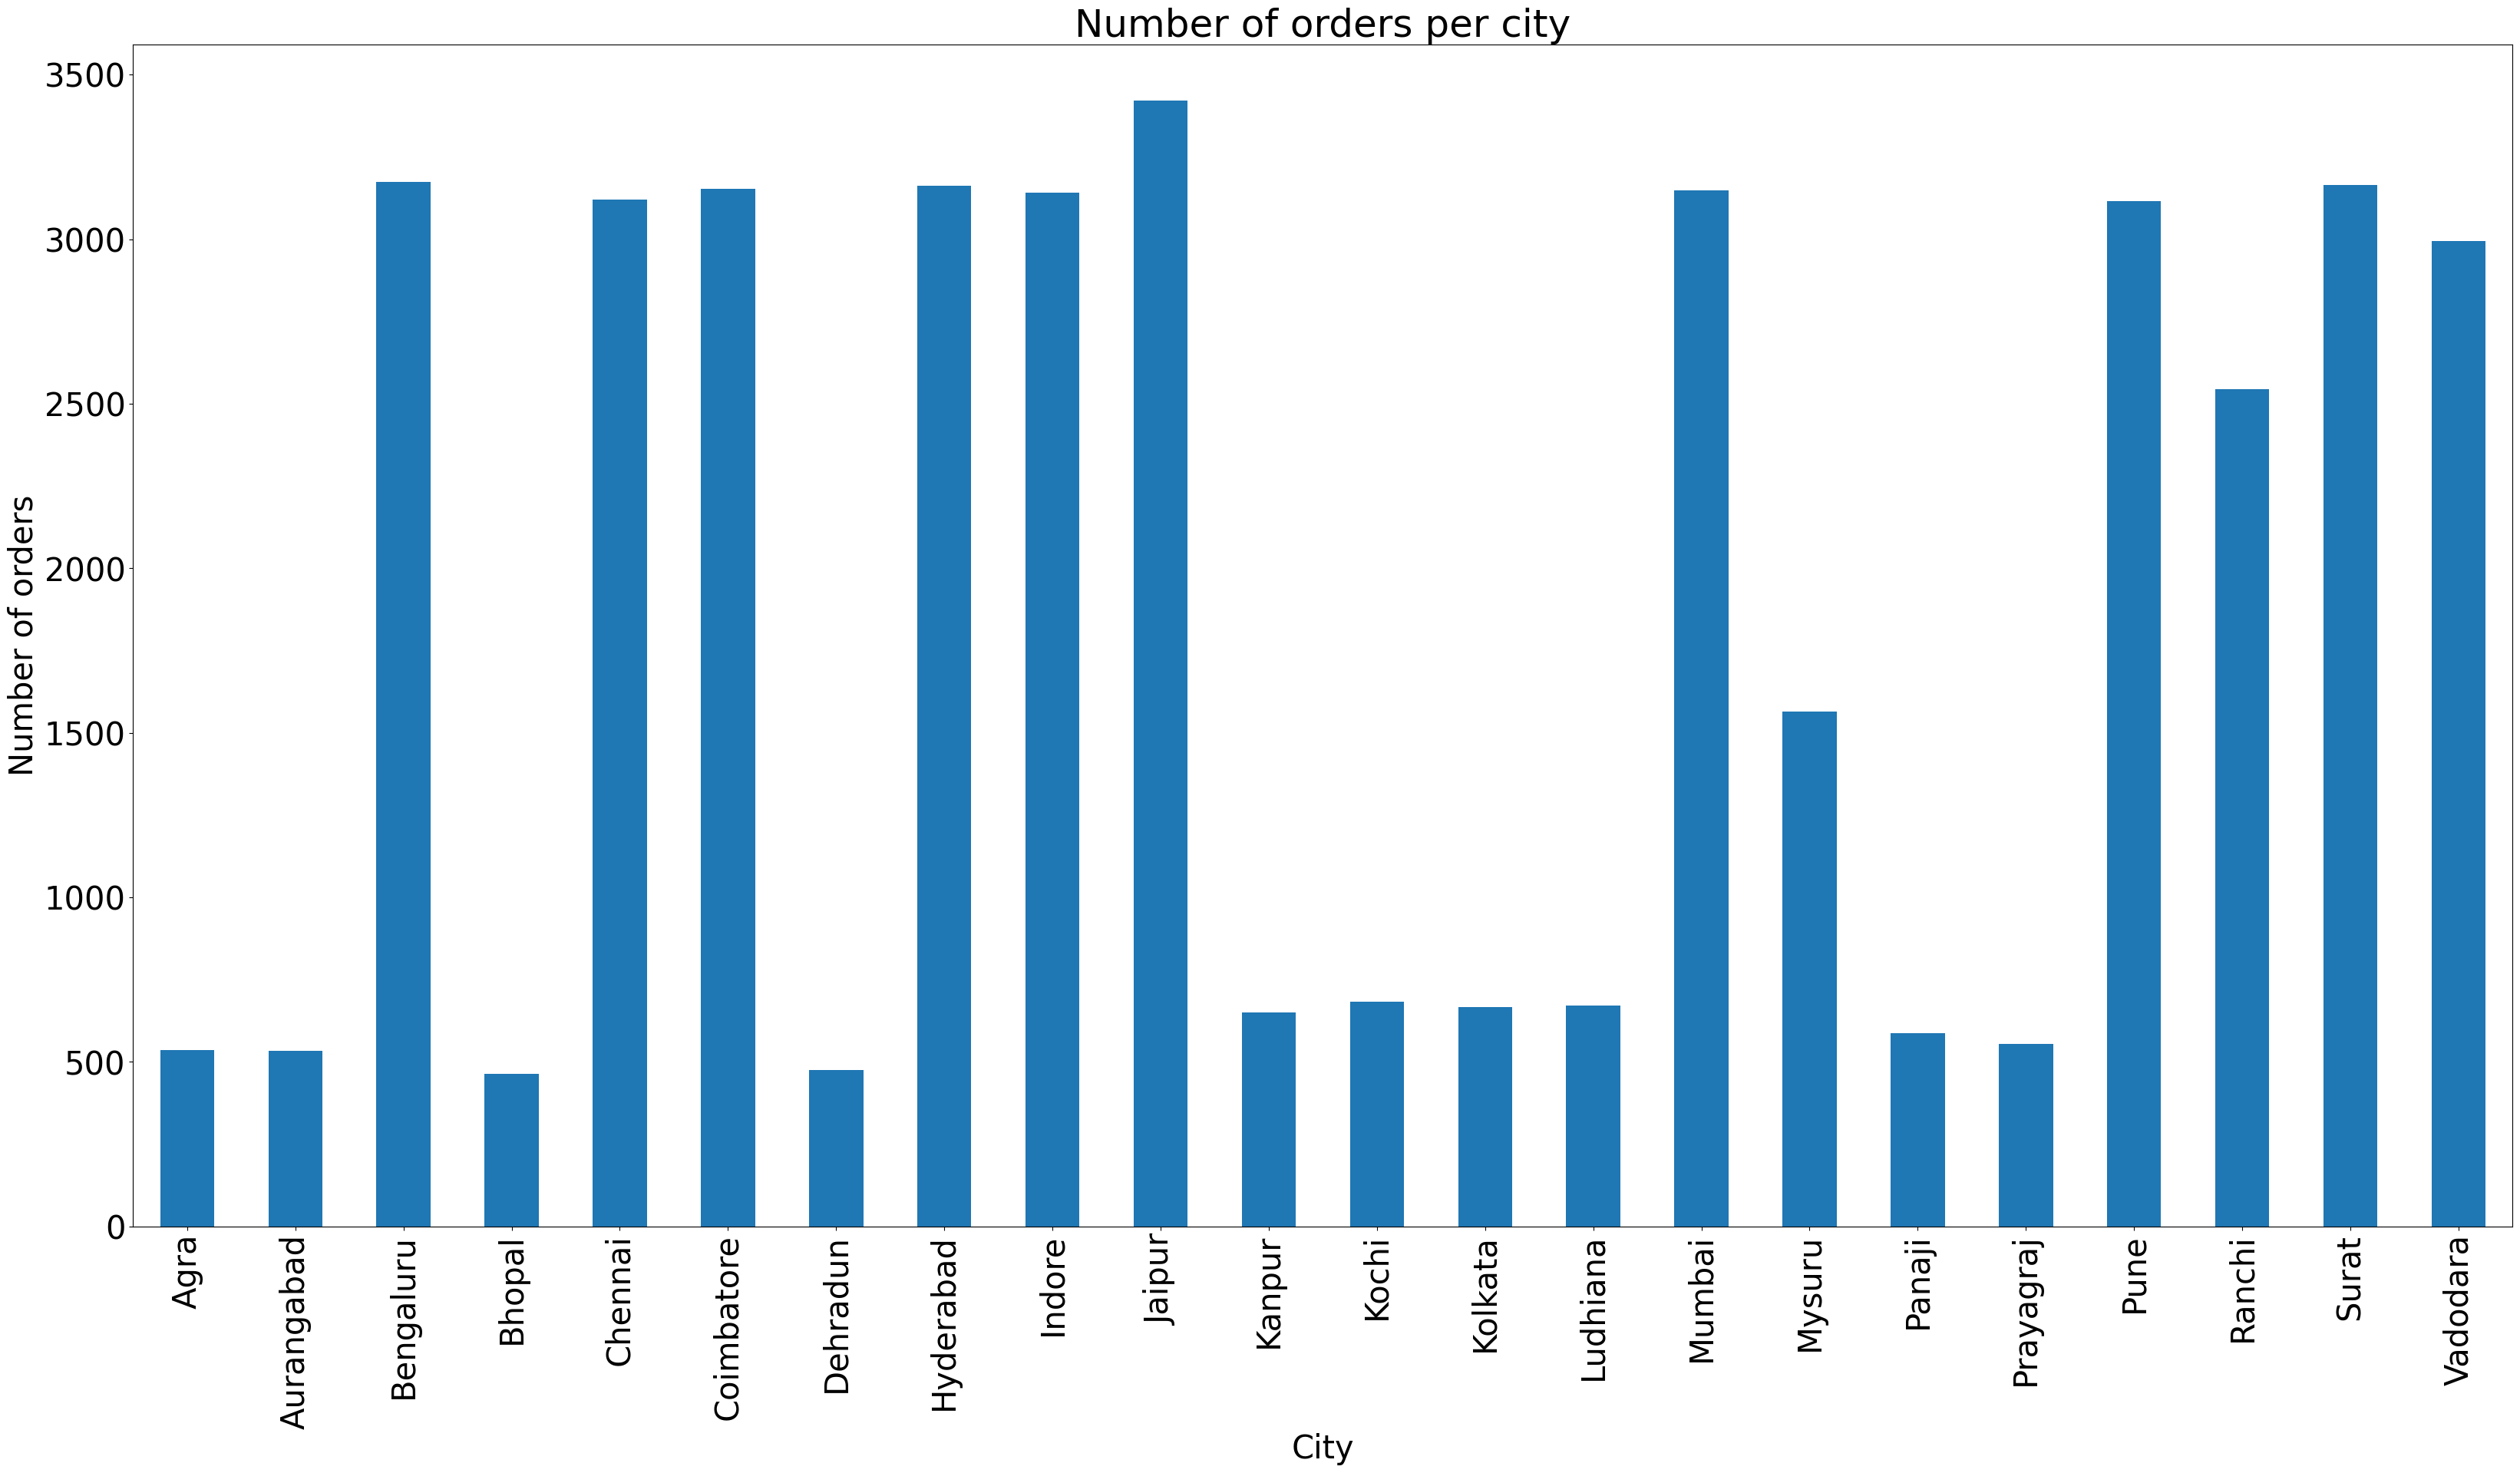

In [45]:
clusters.value_counts().sort_index(ascending=True).plot(kind = 'bar', figsize=(40, 20), title="Number of orders per city", xlabel="City", ylabel="Number of orders")
# ax.title.set_size(30)
# ax.set_xlabel()
plt.rcParams.update({'font.size': 30})